In [ ]:
import os
import sys
import mne
from facet.facet import facet
from loguru import logger
sys.path.append("../../src")
from facet.Epilepsy.template_utils import scale_eeg_to, extract_spike_windows
from facet.Epilepsy.correlation_utils import  find_best_ica, compute_spike_regressors, list_top_spike_channels,  plot_ica_with_annotations
from facet.Epilepsy.shared_utils import build_template
from facet.Epilepsy.localization_utils import make_spike_regressor, localize_evoked, make_spike_evoked
import scipy.stats as st
from scipy.signal import find_peaks
from scipy.io import loadmat
import mne
import numpy as np

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

f = facet()

2025-06-23 01:06:30.374 | ERROR    | facet.helpers.fastranc:<module>:23 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll does not exist. Run the build.py script to create the file.
2025-06-23 01:06:30.375 | ERROR    | facet.helpers.fastranc:<module>:40 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll could not be opened! Check your Project Files Message: Could not find module 'c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers\fastranc.dll' (or one of its dependencies). Try using the full path with constructor syntax.
2025-06-23 01:06:30.376 | INFO     | facet.helpers.fastranc:<module>:41 - Current working directory: g:\Medical Engineering and Analytics\Project\FACETpy\examples\epilepsynotebooks


▶ Before filtering: max ≈ 6227.9 µV, min ≈ -3079.8 µV
▶ After filtering:  max ≈ 2212.7 µV, min ≈ -2249.2 µV


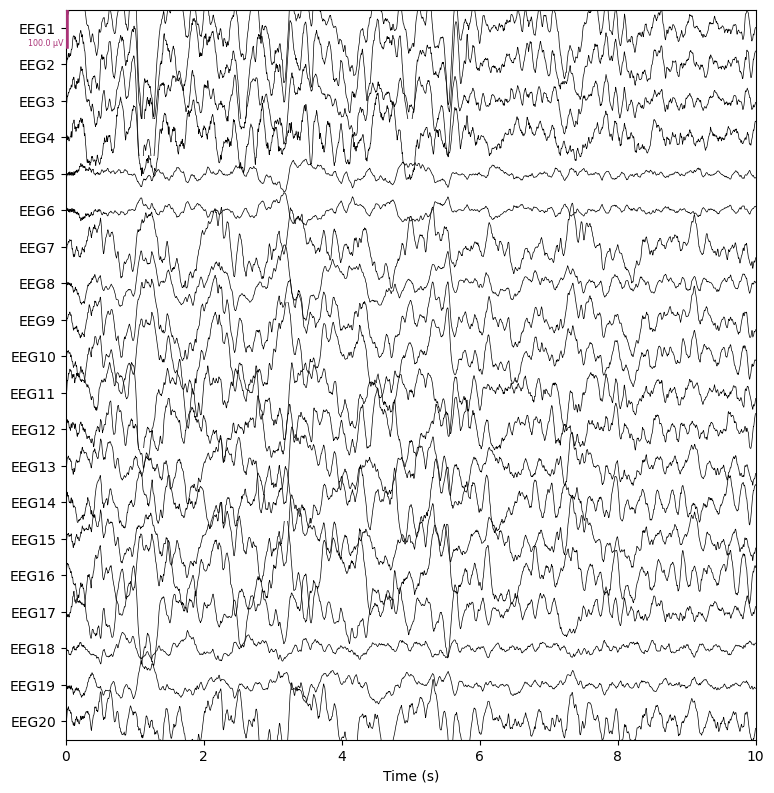

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat

# 1) Load the .mat file
path = r"G:\Medical Engineering and Analytics\Project\FACETpy\examples\datasets\MAT_Files\DA00100V.mat"

mat = loadmat(path)
eeg = mat['eeg_data']  # shape (n_ch, n_samples), raw numbers   
# 2) Build an MNE RawArray in volts
sfreq   = 500.0  # Hz
ch_names = [f"EEG{i+1}" for i in range(eeg.shape[0])]
info     = mne.create_info(ch_names, sfreq, ch_types="eeg")
raw      = mne.io.RawArray(eeg, info)

# 3) Print basic stats in µV
before_max_uv = raw.get_data().max() * 1e6
before_min_uv = raw.get_data().min() * 1e6
print(f"▶ Before filtering: max ≈ {before_max_uv:.1f} µV, min ≈ {before_min_uv:.1f} µV")

# 4) Notch + band-pass (all in volts!)
raw.notch_filter([50, 100], picks="eeg", verbose=False)
raw.filter(1.0, 70.0, picks="eeg", verbose=False)

# 5) Print stats *after* filtering (still in volts internally)
after_max_uv = raw.get_data().max() * 1e6
after_min_uv = raw.get_data().min() * 1e6
print(f"▶ After filtering:  max ≈ {after_max_uv:.1f} µV, min ≈ {after_min_uv:.1f} µV")


# 7) MNE browser with a fixed  µV scale
scalings = {"eeg": 50e-6}
raw.plot(duration=10, scalings=scalings, show_scrollbars=False)
plt.close("all")


### PRINT annotation times

In [4]:

events = mat['events']
for row in events:
    time_str, _, label = row
    print("Label:", label, "at time (s):", float(time_str))


Label: Sleeping                         at time (s): 0.45
Label: !                                at time (s): 35.706
Label: !                                at time (s): 53.14
Label: !                                at time (s): 78.78
Label: !                                at time (s): 112.38
Label: !                                at time (s): 144.548
Label: !                                at time (s): 145.182
Label: !                                at time (s): 187.222
Label: !                                at time (s): 231.82
Label: !                                at time (s): 311.02
Label: Sleeping                         at time (s): 323.88
Label: !                                at time (s): 359.16
Label: !                                at time (s): 425.85
Label: !                                at time (s): 431.05
Label: !                                at time (s): 448.814
Label: !                                at time (s): 457.686
Label: Sleeping                        

### MANUALLY SLICE SPIKE WINDOW

found 52 spikes


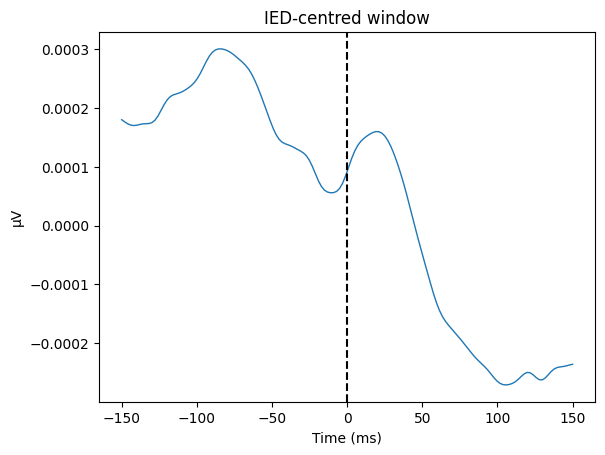

segments.shape = (52, 150)


In [5]:

chan_idx   = 0      # channel you want
half_win_s = 0.15   # 100 ms before & after the spike

# grab the spike times (seconds) 
events = mat["events"]
spike_sec = [float(r[0]) for r in events if r[2].strip() == "!"]
print(f"found {len(spike_sec)} spikes")

# extract windows
segments, times = extract_spike_windows(raw, spike_sec, chan_idx, half_win_s)
print("segments.shape =", segments.shape)


### BUILD TEMPLATE

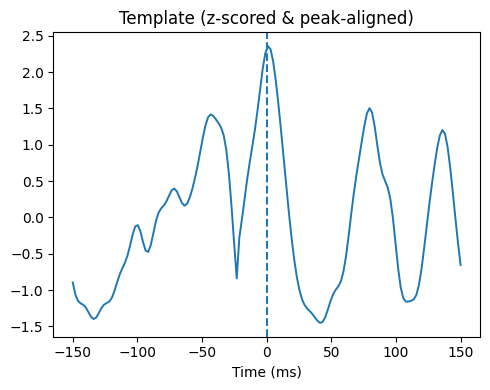

In [6]:
best_ch, template_z, half_shift = build_template(raw, spike_sec, half_win_s=0.15)

### CORRELATION ICA

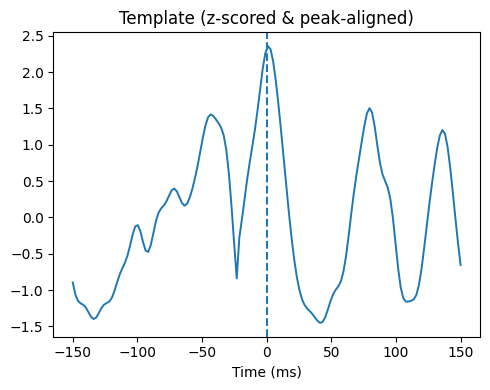

Caught  1/52 spikes within ±0.1s:
  → caught: [797.96]
  → missed: [35.706, 53.14, 78.78, 112.38, 144.548, 145.182, 187.222, 231.82, 311.02, 359.16, 425.85, 431.05, 448.814, 457.686, 543.982, 566.048, 611.618, 649.826, 679.658, 681.806, 683.758, 712.44, 712.892, 713.604, 713.944, 727.18, 766.93, 767.398, 799.154, 855.706, 872.64, 873.214, 893.384, 914.22, 919.24, 919.996, 946.388, 946.886, 947.574, 955.732, 1004.26, 1033.774, 1039.792, 1065.82, 1115.368, 1116.33, 1151.114, 1184.544, 1223.508, 1246.542, 1258.996]


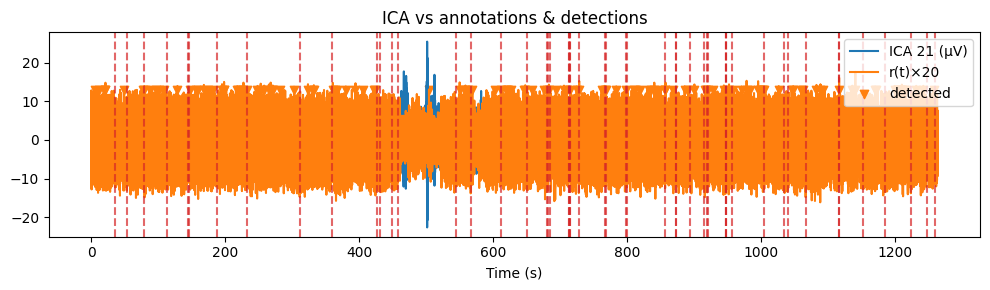

True positives  : 1 detections at [798.02]
False positives : 126 detections at [6.074, 11.436, 18.702, 20.2, 21.118, 48.978, 76.66, 79.286, 86.954, 96.734]…


In [7]:

# run  existing pipeline *unchanged*, with th_ica=0.85:
template_z, r_raw, r_ica, peaks_raw, peaks_ica, best_ch, best_ica_idx, caught, missed = \
    compute_spike_regressors(raw, spike_sec,
                             half_win_s=0.15,
                             th_raw=0.35, th_ica=0.65,
                             min_dist_s=0.3,
                             match_tol_s=0.1)

det_times = peaks_ica / sfreq

# true positives: any det_time within ±tol of any manual time
tol = 0.1
true_pos = [t for t in det_times
            if any(abs(t - s) <= tol for s in spike_sec)]
false_pos = [t for t in det_times
             if all(abs(t - s) > tol for s in spike_sec)]

print(f"True positives  : {len(true_pos)} detections at {true_pos}")
print(f"False positives : {len(false_pos)} detections at {false_pos[:10]}…")


In [8]:
# get the ICA time series in µV
_, ica_trace, _ = find_best_ica(raw, template_z, half_shift)

# now plot
plot_ica_with_annotations(raw, ica_trace, peaks_ica, spike_sec,
                          match_tol_s=0.1, tmin=300, tmax=310)

KeyboardInterrupt: 

### CONTINUOUS REGRESSOR

In [10]:

true_samps = [int(round(t * sfreq)) for t in true_pos]
true_samps = np.asarray(true_samps)

# Use tr=1/sfreq if you want a regressor at EEG rate
regressor = make_spike_regressor(true_samps, raw,
                                 hrf_length_s=32.0,
                                 tr=1.0/raw.info['sfreq'])

KeyboardInterrupt: 

### Build an “IED evoked” by averaging detected ICA spikes

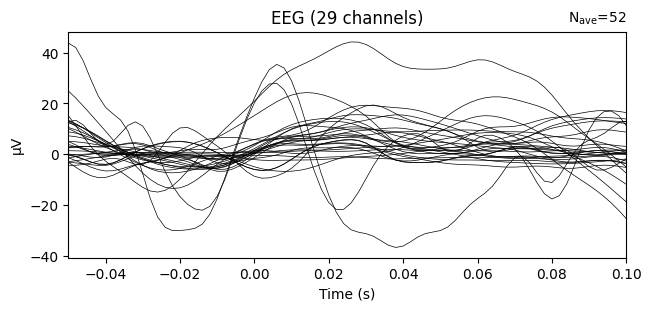

In [11]:
evoked_spike = make_spike_evoked(raw, spike_sec,
                                 tmin=-0.05,   # 50 ms before
                                 tmax=+0.10)  # 100 ms after
evoked_spike.plot(time_unit='s', spatial_colors=True);

### Fit a single equivalent current dipole with a 3-sphere head model

In [ ]:

sfreq  = raw.info['sfreq']
# spike_sec is  list of annotated times in seconds
events = np.array([[int(t * sfreq), 0, 1] for t in spike_sec])
event_id = dict(spike=1)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin=-0.05,        # 50 ms before
    tmax=+0.05,        # 50 ms after
    baseline=(None, 0),# use the full pre‐spike window as baseline
    preload=True
)

cov = mne.compute_covariance(
    epochs,        
    tmin=None,
    tmax=0.0,       
    method='empirical'
)

# Average epochs to one EvokedArray
evoked_spike = epochs['spike'].average()


### 2D VISUALIZATION

AttributeError: 'EvokedArray' object has no attribute 'event_id'